W ramach projektu zaliczeniowego na podstawie danych dziennych przebiegających przez min. 8 lat (np. 2018-2025) należy:

- opisać empiryczny rozkład stóp zwrotu (wyświetlić statystyki opisowe oraz skomentować kluczowe wyniki).
- za pomocą min. dwóch testów normalności sprawdzić, czy dane dzienne spełniają założenie o normalności.
- dwoma wybranymi wersjami metody historycznej (prosta metoda historyczna, metoda historyczna z wagami, metoda uwzględniająca heteroskedastyczność poprzez EWMA lub model GARCH(1,1), metoda Monte Carlo)  w oparciu o 500-dniowe okno historyczne, zbudować szereg oszacowań 99% VaR i 99% ES.
- w oparciu o wyniki testów wstecznych (dla długości m = 250) odpowiedzieć na pytanie, czy wyznaczony VaR jest wyznaczony wiarygodnie (tj. nie jest zawyżony ani zaniżony). Czy owe wyniki pozwalają twierdzić, że obie metody dają wiarygodne oszacowania?
Uwaga: Każda praca będzie podlegała osobistej obronie (na żywo). W jej ramach będę weryfikował rozumienie kluczowych pojęć (definicja VaR i ES, rozumienie wybranych technik liczenia VaR i ES, rozumienie istoty testów wstecznych), a także sprawdzał samodzielność wykonanej pracy.

Praca zaliczeniowa ani jej recenzja NIE MOŻE  być wygenerowana przez sztuczną inteligencję (np. poprzez wygenerowanie tekstu interpretacji czy wygenerowanie znaczącej części kodu). W przypadku stwierdzenia takiego faktu podczas obrony, niezależnie od wyników uzyskanych w ramach projektu, wystawię ocenę 2.0.

In [45]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Ładownaie danych

Ładuję dane z pliku csv. Są to dzienne zwroty Bitcoina w stosunku do dolara amerykańskiego na przestrzeni lat.

In [18]:
CSV_PATH = Path('../data/btcusd_d.csv')

data_btcusdt_frame_daily: pd.DataFrame = pd.read_csv(
        CSV_PATH,
        usecols=['datetime', 'open', 'high', 'low', 'close'],
        parse_dates=['datetime']
    )
# Ustawiam odpowiednio indeks
data_btcusdt_frame_daily.set_index('datetime').sort_index().astype('float64')  

# konwersja kolumny 'Data' na datetime, bo bez tego są błedne daty
data_btcusdt_frame_daily['datetime'] = pd.to_datetime(data_btcusdt_frame_daily['datetime'], errors='coerce')

# usuwam ewentualne błędne wiersze bez dat
data_btcusdt_frame_daily = data_btcusdt_frame_daily.dropna(subset=['datetime'])

# indeks i sortuje
data_btcusdt_frame_daily = (
    data_btcusdt_frame_daily
    .set_index('datetime')
    .sort_index()
    .astype('float64')
)

# Początkowe 10 wierszy
print(data_btcusdt_frame_daily.head(10))

               open     high      low    close
datetime                                      
2010-07-17  0.04951  0.04951  0.04951  0.04951
2010-07-18  0.08584  0.08584  0.08584  0.08584
2010-07-19  0.08080  0.08080  0.08080  0.08080
2010-07-20  0.07474  0.07474  0.07474  0.07474
2010-07-21  0.07921  0.07921  0.07921  0.07921
2010-07-22  0.05050  0.05050  0.05050  0.05050
2010-07-23  0.06262  0.06262  0.06262  0.06262
2010-07-24  0.05454  0.05454  0.05454  0.05454
2010-07-25  0.05050  0.05050  0.05050  0.05050
2010-07-26  0.05600  0.05600  0.05600  0.05600


## Wykres Bitcoina

Na wstępie narysukę wykres ceny Bitcoina, by sprawdzić czy dane wyglądają poprawnie i czy nie ma jakiegoś problemu z nimi.

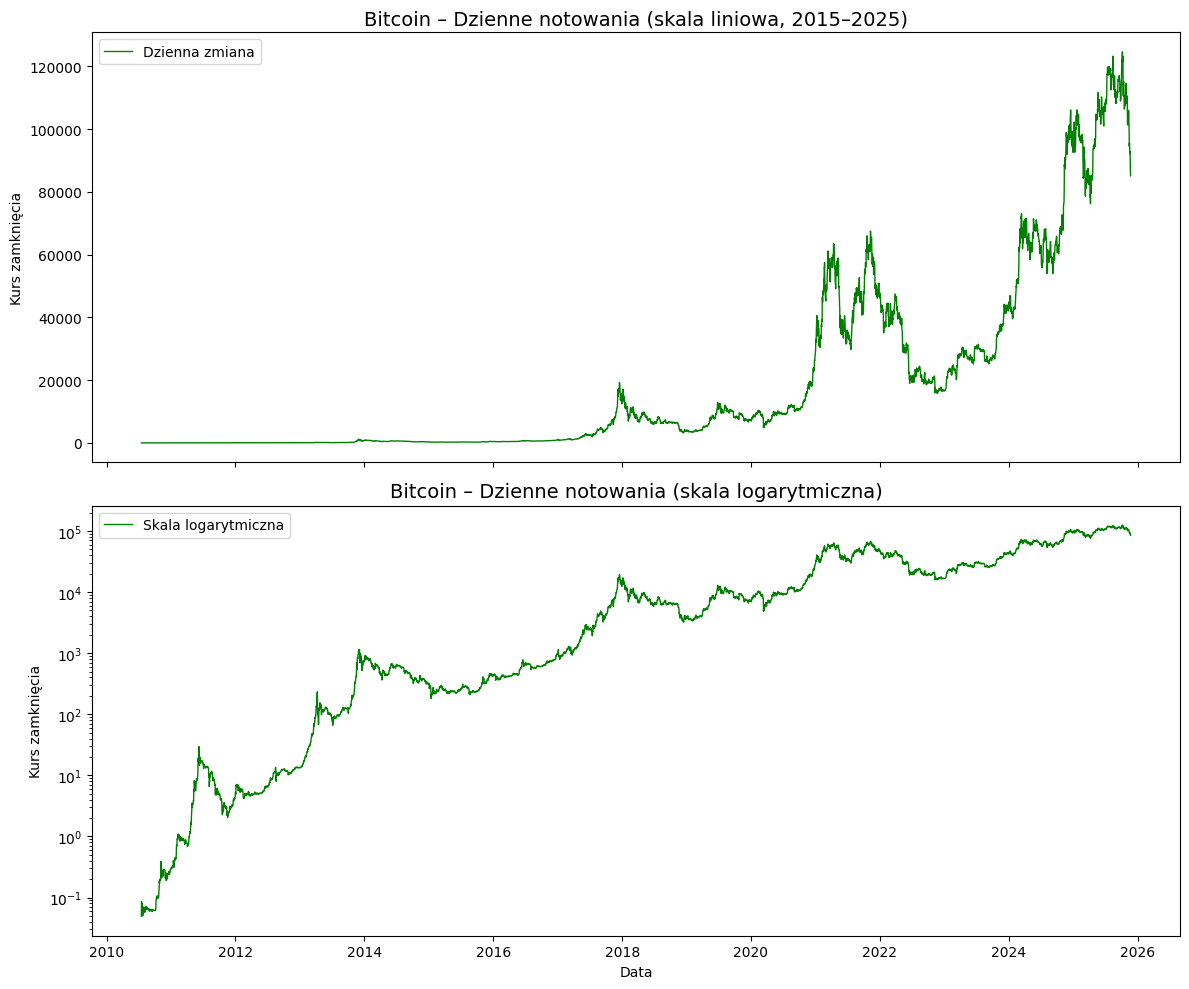

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

axes[0].plot(
    data_btcusdt_frame_daily.index,
    data_btcusdt_frame_daily['close'],
    label='Dzienna zmiana',
    color='green',
    linewidth=1
)
axes[0].set_title('Bitcoin – Dzienne notowania (skala liniowa, 2015–2025)', fontsize=14)
axes[0].set_ylabel('Kurs zamknięcia')
axes[0].legend()

axes[1].plot(
    data_btcusdt_frame_daily.index,
    data_btcusdt_frame_daily['close'],
    label='Skala logarytmiczna',
    color='green',
    linewidth=1
)
axes[1].set_title('Bitcoin – Dzienne notowania (skala logarytmiczna)', fontsize=14)
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Kurs zamknięcia')
axes[1].set_yscale('log')
axes[1].legend()

plt.tight_layout()
plt.show()

Dane wyglądają poprawnie. Dodałem także wykres w skali logarytmicznej, by lepiej podejrzeć jak wyglądała zmienność Bitcoina w jego wczesnych latach.
Jak możemy zauważyć, początkowo zmienność była bardzo spora, a z czasem zaczyna ona maleć.
Nie jest to żadnym zaskoczeniem, tak często zachowują się młode aktywa, które dopiero z czasem i adopcją nabierają stabilności.

Z racji iż projekt ma zawierać zakres 2018-2025, przytnę teraz dane, jednak chciałbym zostawić ich trochę więcej, by móc zobaczyć jak zmieniał się VaR na przestrzeni czasu wraz ze stabilizującymi się notowaniami Bitcoina.
Dlatego mój zakres badania będzie od 2015 roku do 2025 roku (do daty do której pobrałem dane w tamtym momencie, czyli 21 listopada 2025).
Mam nadzieję, że wyłamanie się z zakresu i wydłużenie zakresu badania nie wpływnie negatywnie na ocenę.

In [20]:
START_DATE = "2015-01-01"
data_btcusdt_frame_daily_2015 = data_btcusdt_frame_daily.loc[START_DATE:].copy()

# Sprawdzam czy są braki w danych dziennych
start_date = data_btcusdt_frame_daily_2015.index.min()
end_date = data_btcusdt_frame_daily_2015.index.max()
expected_obs = (end_date - start_date).days + 1
actual_obs = len(data_btcusdt_frame_daily_2015)
missing_obs = expected_obs - actual_obs

print(
    f"Zakres dat po przycięciu: {start_date.date()}; {end_date.date()} "
    f"(liczba obserwacji: {actual_obs})"
)

print(f"Teoretycznie dziennych obserwacji powinno być: {expected_obs}. ")
if missing_obs > 0:
    print(f"Brakuje: {missing_obs} dni.")
else:
    print("Wszystkie dane są poprawne, nie brakuje żadnych dziennych zwrotów.")

print(data_btcusdt_frame_daily_2015.head())

# W dalszej części będę pracował na przyciętych danych
# data_btcusdt_frame_daily = data_btcusdt_frame_daily_2015

Zakres dat po przycięciu: 2015-01-01; 2025-11-21 (liczba obserwacji: 3978)
Teoretycznie dziennych obserwacji powinno być: 3978. 
Wszystkie dane są poprawne, nie brakuje żadnych dziennych zwrotów.
              open        high     low   close
datetime                                      
2015-01-01  322.31  324.997030  313.81  314.96
2015-01-02  314.54  319.999990  313.28  315.81
2015-01-03  315.80  315.990000  277.50  279.30
2015-01-04  279.30  288.740000  255.03  264.19
2015-01-05  264.04  280.410588  263.75  274.84


## Stopy zwrotu Bitcoina

Teraz tworzę funkcje pomocnicze, które pozwolą mi na łatwe wyznaczanie stóp zwrotu (prostą i logarytmiczną)
Wykorzystuję do tego funkcje pomocnicze z poprzednich ćwiczeń z tą różnicą, iż zamiast zwracać zwroty w procentach, będę je zwracac w ułamkach.
W dalszej części projektu skupię się na analizie **stóp logarytmicznych**.

In [21]:
def compute_returns(series: pd.Series) -> pd.DataFrame:
    returns = pd.DataFrame(index=series.index)
    returns["simple_frac"] = (series - series.shift(1)) / series.shift(1)
    returns["log_frac"] = np.log(series / series.shift(1))
    return returns

def plot_returns(df: pd.DataFrame, title: str):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df.index, df["simple_frac"], label="Stopa prosta")
    ax.plot(df.index, df["log_frac"], label="Stopa logarytmiczna")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Data")
    ax.set_ylabel("Stopa zwrotu (%)")
    ax.legend()

    plt.tight_layout()
    plt.show()

            simple_frac  log_frac
datetime                         
2025-11-12    -0.013629 -0.013723
2025-11-13    -0.019304 -0.019493
2025-11-14    -0.051138 -0.052492
2025-11-15     0.010595  0.010539
2025-11-16    -0.013963 -0.014061
2025-11-17    -0.021709 -0.021948
2025-11-18     0.008086  0.008054
2025-11-19    -0.015123 -0.015239
2025-11-20    -0.053713 -0.055210
2025-11-21    -0.017404 -0.017557


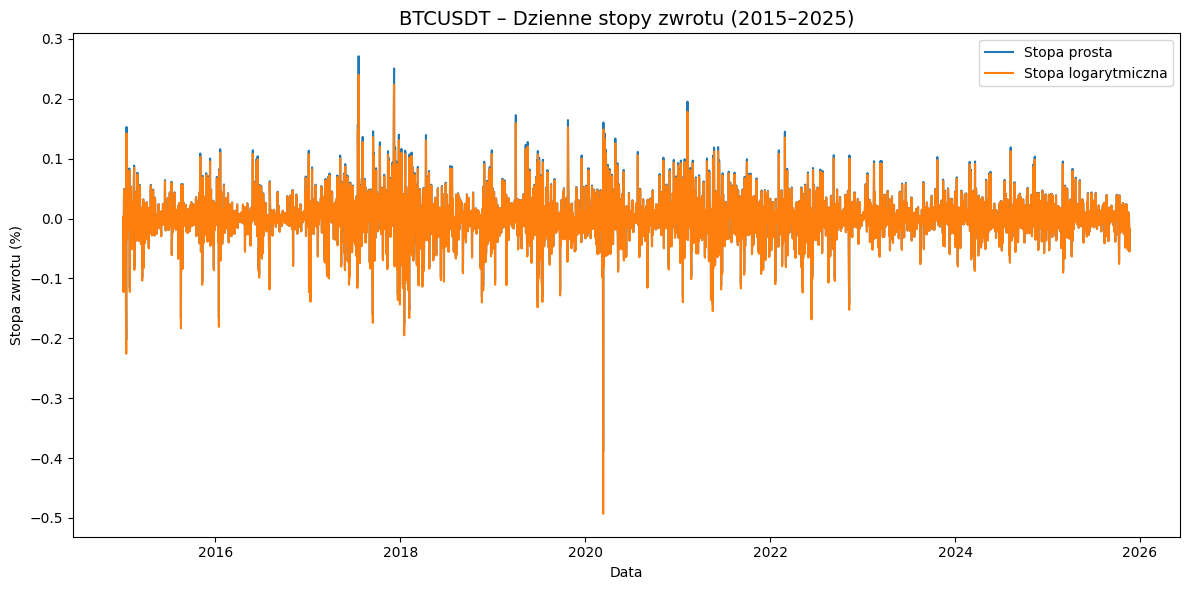

In [22]:
returns_daily = compute_returns(data_btcusdt_frame_daily_2015["close"])
returns_daily = returns_daily.dropna()
returns_daily_log = returns_daily["log_frac"]

print(returns_daily.tail(10))
plot_returns(returns_daily, "BTCUSDT – Dzienne stopy zwrotu (2015–2025)")

Jak możemy zauważyć po wykresie zwrotów, Bitcoin charakteryzuje się bardzo mocnymi wahaniami wyceny. Co jest jednocześnie jego plusem i minusem w zależności jakeigo typu inwestorem jesteśmy.
Można też bardzo szybko zauważyć crash covidowy, który spowodował mocne spadki na giełdach. Nie omineło to także Bitcoina, gdzie możemy zauważyć ~50% spadek według stopy logarytmicznej.

In [23]:
# Statystyki opisowe dziennych stóp zwrotu (w %)
returns_pct = returns_daily[["simple_frac", "log_frac"]] * 100
returns_daily_log_pct = returns_pct["log_frac"]

stats_desc = returns_pct.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
tail_desc = returns_pct.agg(['skew', 'kurtosis']).T

print("Statystyki opisowe dziennych stóp zwrotu (w %):")
print(stats_desc.to_string(float_format=lambda x: f"{x:0.4f}"))

print("\nSkośność i kurtoza:")
print(tail_desc.to_string(float_format=lambda x: f"{x:0.2f}"))

Statystyki opisowe dziennych stóp zwrotu (w %):
                count   mean    std      min       1%      5%    50%    95%     99%     max
simple_frac 3977.0000 0.2061 3.5967 -38.9320 -10.4621 -5.5213 0.1301 5.7446 10.6091 27.1104
log_frac    3977.0000 0.1408 3.6239 -49.3182 -11.0508 -5.6796 0.1300 5.5856 10.0832 23.9886

Skośność i kurtoza:
             skew  kurtosis
simple_frac -0.13      7.92
log_frac    -0.78     12.70


Od razu po opisie rozkładu możemy zauważyć, iż istnieje spora różnica między największym zyskiem a największą stratą. Jest to różnica około dwukrotna.
Na wstępie wytłumaczenie mogłoby być takie, że statystykę zniekształca nam "covidowy crash".
Jednak jeśli sprawdzimy percentyle 1% i 99%, a nie tylko ekstrema, zauważymy, iż ten efekt nadal się utrzymuje.

* 1%: `-11.0508`
* 99%: `10.0832`

Jest to różnica około 1 punktu procentowego, co na rynkach finansowych jest wartością dość znaczną.
Przeanalizujemy jeszcze skośność i kurtozę, by potwierdzić, iż częściej występują ekstremalne spadki niż zyski.

Jednak też już teraz mogę założyć, iż ta analiza potwierdzi powyższą tezę. Wynika to z faktu, iż rynki często charakteryzują się tym, że inwestorzy częściej ekstremalnie panikują, powodując jeszcze mocniejsze spadki (boją się większych strat niż te, co mają, dlatego sprzedają), niż reagują na ekstremalne wzrosty. Tutaj działa po prostu ludzka psychika.

**Skośność:**
`-0.78`
Jest wyraźnie ujemna, co oznacza, że "ogon" wykresu po lewej stronie (straty) jest dłuższy i "grubszy" niż po prawej (zyski). Mimo że Bitcoin kojarzy się z wielkimi wzrostami, statystyka ta mówi, że ekstremalne spadki są bardziej prawdopodobne (lub silniejsze) niż ekstremalne wzrosty o tej samej skali.
Sugerowało by to tendencję do występowania tzw. "crashów", czyli nagłych, głębokich załamań cenowych.

**Kurtoza:**
`12.70`
Dla rozkładu normalnego kurtoza wynosi 3 (dla wygody odejmuje się tę wartość i tworzy tzw. "współczynnik ekscesu").
Nasz wynik w porównaniu do tej trójki jest ogromny. Taki wynik oznacza, iż nasz rozkład jest leptokurtyczny (kurtoza > 0), co mówi, że intensywność wartości skrajnych jest większa niż dla rozkładu normalnego.

Obie miary kurtoza i skośność potwierdzają nam, że na rynku Bitcoina często występują skrajne zwroty.

## Histogram stóp zwrotów

In [30]:
# Histogram rozkładu dziennych stóp zwrotu logarytmicznych (w %)
quantiles = returns_daily_log_pct.quantile([0.01, 0.05, 0.5, 0.95, 0.99])

fig_int = px.histogram(
    returns_daily_log_pct,
    nbins=100,
    histnorm="probability density",
    title="Interaktywny histogram stóp zwrotu logarytmicznych (w %)",
    labels={"value": "Dzienna stopa zwrotu (%)"},
)
fig_int.add_vline(x=quantiles.loc[0.01], line_dash="dash", line_color="crimson", annotation_text="1%")
fig_int.add_vline(x=quantiles.loc[0.05], line_dash="dash", line_color="orange", annotation_text="5%")
fig_int.add_vline(x=quantiles.loc[0.95], line_dash="dash", line_color="royalblue", annotation_text="95%")
fig_int.add_vline(x=quantiles.loc[0.99], line_dash="dash", line_color="navy", annotation_text="99%")
fig_int.update_layout(bargap=0.02, showlegend=False)
fig_int.show()

To histogramie widzimy, iż jednak covidowy spadek jest sporym outlinerem. Dlatego dla testu usunę go i jeszcze raz spradzę skośność i kurtozę czy faktycznie sprzyja częstszym drasrycznym spadkom, czy jednak to było tylko przez tego jednego outlinera.

## Histogram stóp zwrotów bez outlinera (Covidowego Crasha)

In [31]:
# Statystyki zwrotów bez największego ujemnego zwrotu z 2020 r. (w %)
covid_min_idx = returns_daily_log_pct.loc['2020'].idxmin()
returns_pct_no_outliers = returns_pct.drop(index=covid_min_idx)

stats_desc_no = returns_pct_no_outliers.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
tail_desc_no = returns_pct_no_outliers.agg(['skew', 'kurtosis']).T

print(f'Liczba obserwacji po filtracji: {len(returns_pct_no_outliers)} ({len(returns_pct)} wcześniej)')
print('Statystyki opisowe (w %):')
print(stats_desc_no.to_string(float_format=lambda x: f"{x:0.4f}"))

print('Skośność i kurtoza (w %):')
print(tail_desc_no.to_string(float_format=lambda x: f"{x:0.2f}"))

Liczba obserwacji po filtracji: 3976 (3977 wcześniej)
Statystyki opisowe (w %):
                count   mean    std      min       1%      5%    50%    95%     99%     max
simple_frac 3976.0000 0.2160 3.5432 -20.1999 -10.4024 -5.5029 0.1306 5.7448 10.6104 27.1104
log_frac    3976.0000 0.1532 3.5384 -22.5646 -10.9842 -5.6602 0.1305 5.5858 10.0844 23.9886
Skośność i kurtoza (w %):
             skew  kurtosis
simple_frac  0.19      4.85
log_frac    -0.16      4.66


Sam rozkład zwrotów percentyli jest niemal identyczny, czego można było się spodziewać, bo usuneliśmy tylko jedną obserwację.
Jednak widać, że wpłyneło to mocno na wartości skośnści i kurtozy.
			
**Skośność**
Przed: -0.78
Po: -0.07

**Kurtoza**
Przed: 12.70
Po: 1.51

Są to bardzo spore różnice, więc w dalszej analizie warto mieć to z tyłu głowy co może wpływać na być może jakieś nieprzewidziane i zaskakujące wyniki.

In [32]:
returns_pct_no_outliers_log = returns_pct_no_outliers['log_frac']
quantiles_no = returns_pct_no_outliers_log.quantile([0.01, 0.05, 0.95, 0.99])
fig_int = px.histogram(
    returns_pct_no_outliers_log,
    nbins=120,
    histnorm='probability density',
    title='Interaktywny histogram stóp zwrotu logarytmicznych (bez wartości odstających)',
    labels={'value': 'Dzienna stopa zwrotu (%)'},
)
fig_int.add_vline(x=quantiles_no.loc[0.01], line_dash='dash', line_color='crimson', annotation_text='1%')
fig_int.add_vline(x=quantiles_no.loc[0.05], line_dash='dash', line_color='orange', annotation_text='5%')
fig_int.add_vline(x=quantiles_no.loc[0.95], line_dash='dash', line_color='royalblue', annotation_text='95%')
fig_int.add_vline(x=quantiles_no.loc[0.99], line_dash='dash', line_color='navy', annotation_text='99%')
fig_int.update_layout(bargap=0.03, showlegend=False)
fig_int.show()


## Testy normalności rozkładu logarytmicznych stóp zwrotu

Teraz aby sprawdzić normalnosć wyników przeprowadzę 4 testy normalności, będą to
- Test Jarque-Bera (JB)
- Test Shapiro-Wilka
- Test Andersona-Darlinga
- Test Kołmogorowa-Smirnowa

In [33]:
import pandas as pd
import scipy.stats as st


def run_tests(series):
    mu, sigma = series.mean(), series.std(ddof=1)

    results = []

    # 1. JB
    jb_stat, jb_p = st.jarque_bera(series)
    results.append(
        {
            "Test": "Jarque-Bera",
            "p-value": f"p={jb_p:}",
            "Czy normalny?": "NIE" if jb_p < 0.05 else "TAK",
        }
    )

    # 2. Shapiro-Wilk
    sw_stat, sw_p = st.shapiro(series)
    results.append(
        {
            "Test": "Shapiro-Wilk",
            "p-value": f"p={sw_p:}",
            "Czy normalny?": "NIE" if sw_p < 0.05 else "TAK",
        }
    )

    # 3. Kołmogorow-Smirnow
    ks_stat, ks_p = st.kstest(series, "norm", args=(mu, sigma))
    results.append(
        {
            "Test": "Kolmogorow-Smirnow",
            "p-value": f"p={ks_p:}",
            "Czy normalny?": "NIE" if ks_p < 0.05 else "TAK",
        }
    )

    # 4. Anderson-Darling (nie ma p-value wprost)
    ad = st.anderson(series, dist="norm")
    # Dla poziomu istotności 5% indeks to 2 (w tablicy: 15%, 10%, 5%, 2.5%, 1%)
    ad_crit_5pct = ad.critical_values[2]
    ad_is_normal = ad.statistic < ad_crit_5pct
    results.append(
        {
            "Test": "Anderson-Darling",
            "p-value": f"Stat={ad.statistic:.2f} (Kryt={ad_crit_5pct:.2f})",
            "Czy normalny?": "TAK" if ad_is_normal else "NIE",
        }
    )

    df_res = pd.DataFrame(results)

    print(f"\nWyniki testów normalnosći logarytmicznych stóp zwrotu")
    print(df_res.to_string(index=False))

run_tests(returns_daily_log_pct)


Wyniki testów normalnosći logarytmicznych stóp zwrotu
              Test                  p-value Czy normalny?
       Jarque-Bera                    p=0.0           NIE
      Shapiro-Wilk  p=4.920491652000817e-44           NIE
Kolmogorow-Smirnow p=1.2620485025175827e-34           NIE
  Anderson-Darling   Stat=83.33 (Kryt=0.79)           NIE


Tak jak możemy wyczytać z wyników, żaden test nie potwierdził normalności rozkładu stóp zwrotu.
Było to do przewidzenia, gdyż aktywa przeważnie nie posiadają stóp zwrotu z rozkładem normalnym, a tmy bardziej można było się tego spodziewać bo świeżym aktywie.

Jarque-Bera daje wartość zera. Jest to wartość spodziewana po tym jak wygląda nasza skośność i kurtoza rozkładu.
Kolejnme dwa tetsy Shapiro-Wilk i Kolmogorow-Smirnow dają wartości niemal bliskie zeru.

Test Anderson-Darling także odrzuca tezę o normalności. Widzimy sporą różnicę między statystyką testu a wartością krytyczną dla poziomu istotności 5%. Moglismy się tego spodizewać bo już poprzednie testy wskazywały nam, że normlaności rozkładu jest definitywnie odrzucana.

Podsumowując, tesy pokazują, że **rozkład logarytmicznych zwrotów nie jest normalny**

## Wyzanczanie VaR i ES przy pomocy EWMA io GARCH(1,1)

Teraz zprzechodzimy do sekcji wyzanczania VaR i ES
Definiuję zmienne pomocnicze którę będę wykorzystywać przez resztę analizy

In [ ]:
WINDOW = 500 # ile dni bierzemy pod uwagę, do wyliczenia VaR/ES
QUANTILE_LEVEL = 0.99  # Czyli 99% VaR
QUANTILE_LEVEL_PERCENTAHE = QUANTILE_LEVEL * 100 # Zamiana na procenty, pomocnicza

losses_daily_log_values = -returns_daily_log.values
losses_daily_log = -losses_daily_log_values

### EWMA (Exponentially Weighted Moving Average)

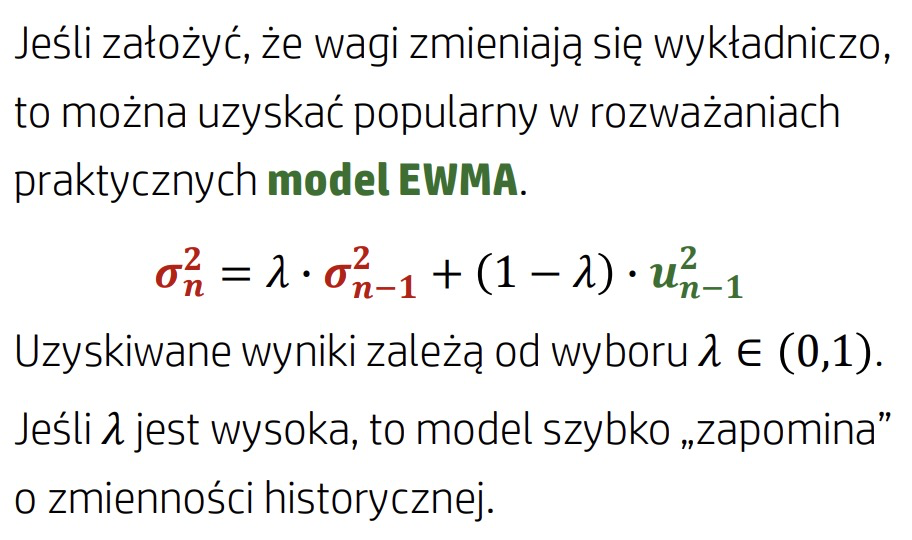

Gdzie:
- sigma_n^2 – bieżąca wariancja (prognoza zmienności).
- sigma_{n-1}^2 – poprzednia wariancja.
- u_{n-1} – ostatni log-zwrot
- lambda ∈ (0,1) – klasycznie to 0.94 i taką też wartość użyjemy na start.


Kos poniżej jest podzielony na dwa bloki.
Pierwszy oblicza dynamiczną wariancję "ręcznie", a na jej podstawie Value at Risk (VaR) oraz Expected Shortfall (ES) przy użyciu modelu EWMA. Model ten nadaje większą wagę nowszym obserwacjom, dzięki czemu szybciej reaguje na zmieniającą się zmienność rynkową.

In [47]:
LAMBDA = 0.94 # Standardowa używana wartość lambda służąca (czynnik zanikania pamięci)

# tablica na wyniki (same zera na start)
sigmas = np.zeros(len(losses_daily_log_values))

# inicjalizacja
# musimy od czegoś zacząć dlatego biorę wariancję z pierwszych 500 dni jako wartość startową
current_var = np.var(losses_daily_log_values[:WINDOW])

# pętla licząca EWMA tak jak wedgług wzoru
for i in range(len(losses_daily_log_values)):
    # Zapisujemy obecną sigmę (pierwiastek z wariancji)
    sigmas[i] = np.sqrt(current_var)
    
    # Aktualizujemy wariancję na kolejny dzień
    # var_new = lambda * var_old + (1-lambda) * zwrot^2
    current_var = LAMBDA * current_var + (1 - LAMBDA) * (losses_daily_log_values[i]**2)

sigma_ewma = pd.Series(sigmas, index=returns_daily_log.index, name="Sigma EWMA")

# Obliczenie EWMA z Pandas (Dla porównania, bo ma wbudowane)
# alpha = 1 - lambda.
# adjust=False sprawia, że liczy to wg wzoru rekurencyjnego (jak w pętli).
# używamy .shift(1) ponieważ nasza pętla zapisuje sigmas[i] przed aktualizacją o losses_daily_log_values[i].
sigma_ewma_pandas = (
    returns_daily_log.pow(2)
    .ewm(alpha=1-LAMBDA, adjust=False)
    .mean()
    .shift(1)
    .pow(0.5)
)
sigma_ewma_pandas.name = "Sigma Pandas"

# góra: Zmienność EWMA (Sigma)
# dół: Dzienne Zwroty
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=("Zmienność Dziennia EWMA (Sigma)", "Dzienne Stopy Zwrotu"),
    row_heights=[0.7, 0.3]
)

# Ręczna
fig.add_trace(go.Scatter(
    x=sigma_ewma.index,
    y=sigma_ewma * 100,
    mode='lines',
    name='Sigma EWMA (Ręczna)',
    line=dict(color='orange', width=2)
), row=1, col=1)

# Pandas (Weryfikacja)
fig.add_trace(go.Scatter(
    x=sigma_ewma_pandas.index,
    y=sigma_ewma_pandas * 100,
    mode='lines',
    name='Sigma EWMA (Pandas)',
    line=dict(color='blue', width=1.5, dash='dash')
), row=1, col=1)


# zwroty
fig.add_trace(go.Scatter(
    x=returns_daily_log.index,
    y=returns_daily_log * 100,
    mode='lines',
    name='Dzienne Zwroty',
    line=dict(color='gray', width=1),
    opacity=0.5
), row=2, col=1)

fig.update_layout(
    title=f"Model EWMA (lambda={LAMBDA}) – Zmienność vs Zwroty",
    template="plotly_white",
    hovermode="x unified",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    height=700
)

fig.update_yaxes(title_text="Zmienność [%]", row=1, col=1)
fig.update_yaxes(title_text="Zwrot [%]", row=2, col=1)

fig.show()

Tak jak możemy zauważyć, moje obliczenia są zgodne z obliczeniami gotowego rozwiązania przez Pnadas.
Widać wyraźnie, że od około roku 2018 zmienność Bitcoina zaczyna maleć wraz z czasem, poza tym jednym covidowym wybiciem.
Jest to najwęŻsza zmienność zanotowana na zakresie naszego projektu.
Dla porównania, pod wykresem EWMA zamieściłem wykres zwrotów.

### VaR i ES przy pomocy EWMA (99%, okno 500)

Wiemy, że rozkład zwrotów nie jest normalny oraz, że nie są one stałe w czasie.
Występuje to zjawisko heteroskedastyczości, czyli widzimy po wykresie, że zmienność jest skupiona.

Dla obliczeń wykorzystamy wzory przedstawione na wykładzie, czyli:

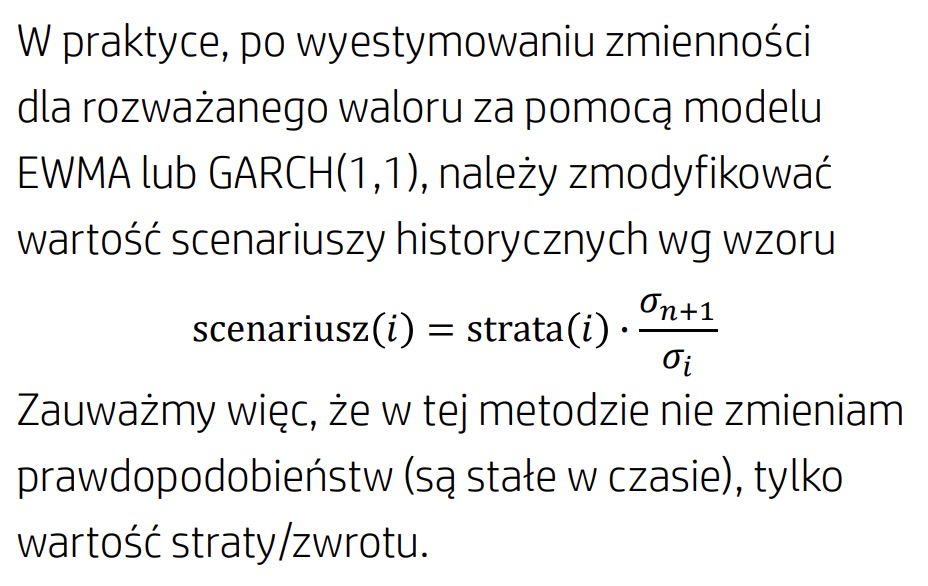

Tłumacząc podan wzór.
Pobieramy WINDOW wartości wstecz (czyli nasze 500).
Wykonujemy standaryzację i skalowanie.
Pętla dla każdej z tych 500 par wykonujemy przeliczenie:
Bierzemy historyczną stratę.
Mnożysz ją przez stosunek: `zmienność_dzisiaj / zmienność_wtedy`.
Otrzymujemy 500 nowych, hipotetycznych strat (scenariuszy) dopasowanych do dzisiejszego ryzyka.
Teraz z tych hipotetycznych 500 scenariuszy możemy wyliczyć prostą metodą VaR i ES

In [51]:
sigma_ewma_values = sigma_ewma.values
dates = returns_daily_log.index

# wyniki
ewma_var_results = []
ewma_es_results = []

# Zaczynamy od dnia WINDOW (czyli 500), bo potrzebujemy historii wstecz
for i in range(WINDOW, len(losses_daily_log_values)):
    
    # dzisiejsza zmienność (prognoza na ten dzień)
    # licznik ułamka: sigma_{n+1}
    current_sigma = sigma_ewma_values[i]
    
    # okno historyczne (ostatnie WINDOW dni)
    # window_losses - 'strata(i)'
    # window_sigmas - 'sigma(i)' (zmienność, która była wtedy)
    window_losses = losses_daily_log_values[i-WINDOW : i]
    window_sigmas = sigma_ewma_values[i-WINDOW : i]
    
    # Tworzymy WINDOW hipotetycznych scenariuszy (wzór orginalny)
    scaled_scenarios = window_losses * (current_sigma / window_sigmas)
    
    # Wyliczenie VaR (99-ty percentyl ze scenariuszy)
    var_val = np.quantile(scaled_scenarios, QUANTILE_LEVEL)
    
    # Wyliczenie ES (średnia ze scenariuszy gorszych niż VaR)
    es_val = scaled_scenarios[scaled_scenarios >= var_val].mean()
    
    ewma_var_results.append(var_val)
    ewma_es_results.append(es_val)

# Indeks musi zaczynać się od daty WINDOW, bo wcześniej nie mamy wyników
results_index = dates[WINDOW:]

ewma_var_series = pd.Series(ewma_var_results, index=results_index, name="VaR 99% (EWMA)")
ewma_es_series = pd.Series(ewma_es_results, index=results_index, name="ES 99% (EWMA)")

print("Ostatnie 5 wyników VaR:")
print(ewma_var_series.tail())

Ostatnie 5 wyników VaR:
datetime
2025-11-17    0.067907
2025-11-18    0.067640
2025-11-19    0.065826
2025-11-20    0.064723
2025-11-21    0.073892
Name: VaR 99% (EWMA), dtype: float64


In [52]:
fig = go.Figure()

# rzeczywiste straty (żeby widzieć skuteczność modelu)
fig.add_trace(go.Scatter(
    x=results_index,
    y=losses_daily_log_values[WINDOW:] * 100,
    mode='lines',
    name='Rzeczywista Strata (Log)',
    line=dict(color='silver', width=1),
    opacity=0.4
))

# VaR
fig.add_trace(go.Scatter(
    x=ewma_var_series.index,
    y=ewma_var_series * 100,
    mode='lines',
    name='VaR 99% (EWMA)',
    line=dict(color='red', width=1.5)
))

# ES
fig.add_trace(go.Scatter(
    x=ewma_es_series.index,
    y=ewma_es_series * 100,
    mode='lines',
    name='ES 99% (EWMA)',
    line=dict(color='black', width=1.5, dash='dot')
))

fig.update_layout(
    title=f"VaR i ES metodą historyczną ze skalowaniem zmiennością (EWMA λ={LAMBDA})",
    xaxis_title="Data",
    yaxis_title="Strata [%]",
    template="plotly_white",
    hovermode="x unified",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Dla sprawdzenia poprawności metody, przedstawiłem na wykresie wszystkie trzy interesujące nas zmienne:
- VaR
- ES
- Straty

Początkowo VaR i ES wyglądają zby ekstremalnie, jednak po przybliżeniu w interesujące nas momenty, np:
- marzec 2020
- listopad 2022
- luty 2025

Widzimy iż są to faktycznie momenty, gdy nasz VaR 99% został przekroczony (a na przestrzenie całego zakresu badania tak być powinno bo mamy ten zapas 1%)
Widzimy też mocny wpływ zmienności w przypadku crashu covidowego, co widać na ES, które wyskoczyło na ponad 80% (ze względu na skalowalność). Było to ze względu na to, iż zmienność przed crashem była dość mała.

### GARCH(1,1)

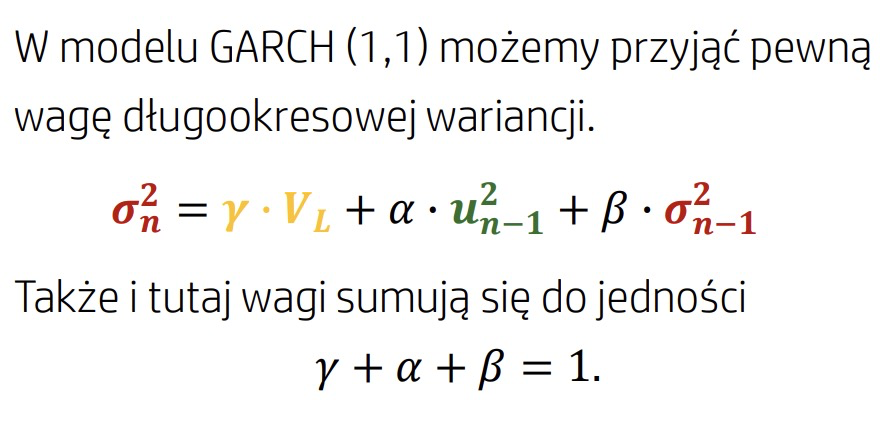

Wzór GARCH(1,1) jest w zasadzie dość podobny do EWMA pod względem struktóry, z tym, że dochodzi nam jedna nowa stała `y * Vl`

Do wyznaczenia parametrów dla wzoru użyjemy gotowej bilbioteki `arch`

In [ ]:
from arch import arch_model

# GARCH najlepiej liczy się na danych przeskalowanych (np. procentach, a nie ułamkach, dlatego używamy procenty)
returns_values = returns_daily_log_pct.values

# używamy billioteki do dopasowania parametrów
# tworzymy model GARCH(1,1)
model = arch_model(returns_daily_log_pct.values, vol='Garch', p=1, q=1, rescale=False)
model_fit = model.fit(disp='off')

# wyliczone parametry
omega = model_fit.params['omega']
alpha = model_fit.params['alpha[1]']
beta = model_fit.params['beta[1]']

print(f"\nWyestymowane parametry GARCH(1,1):")
print(f"Omega (waga długookresowa, ma w sobie ten Y ze wzoru - Wariancję Długoterminową): {omega:.6f}")
print(f"Alpha (zwrot u^2): {alpha:.6f}")
print(f"Beta  (sigma^2): {beta:.6f}")
sum_coef = alpha + beta
print(f"Suma (Alpha + Beta): {sum_coef:.6f}") # (powinna być < 1 dla stabilności)


Wyestymowane parametry GARCH(1,1):
Omega (waga długookresowa, ma w sobie ten Y ze wzoru - Wariancję Długoterminową): 0.438161
Alpha (zwrot u^2): 0.118733
Beta  (sigma^2): 0.858356
Suma (Alpha + Beta): 0.977090


In [ ]:
# Obliczamy Long Run Variance (V_L ze wzoru), przekształcamy wzór: omega / (1 - alpha - beta)
long_run_variance = omega / (1 - sum_coef)
long_run_sigma = np.sqrt(long_run_variance)

print(f"Długoterminowa wariancja (V_L): {long_run_variance:.4f}")
print(f"Długoterminowa zmienność dzienna: {long_run_sigma:.2f}%")

Suma Alpha + Beta: 0.977090
Model jest STABILNY (stationary).
Długoterminowa wariancja (V_L): 19.1250
Długoterminowa zmienność dzienna: 4.37%


Z racji iż większość bibliotek podaje nam gotowe parametry omega alfa, beta, to musiałem przekształcić wyniki by wydobyć z danych nasz V_L czyli Wariancję Długoterminową.
Robię to też dlatego, bo dzięki niej możemy odpowiedzieć na pytanie jak w długim terminie zachowuje się zmienność Bitcoina.
Interpretować nasz wynik możemy w ten sposób: **Chwilowo zmienność może być 2% albo 10%, ale w bardzo długim terminie Bitcoin ma tendencję do posiadania dziennej zmienności w okolicach 4.37%.**

Mamy już parametry do modelu GARCH(1,1), więc teraz przechodzimy do dalszej części.
Obliczymy zmienność za pomocą naszego modelu, a następnie przy jej pomocy wyzanczymy znów VaR i ES.

In [62]:
# GARCH liczyliśmy na procentach, więc tutaj też operujemy na procentach
garch_sigmas_sq = np.zeros(len(returns_daily_log_pct.values))

# musimy od czegoś zacząć dlatego biorę wariancję z pierwszych 500 dni jako wartość startową
current_var = np.var(returns_daily_log_pct.values[:WINDOW])
garch_sigmas_sq[0] = current_var

# Implementacja wzoru: sigma^2 = omega + alpha * u^2 + beta * sigma^2
for i in range(1, len(returns_daily_log_pct.values)):
    # Pobieramy wartości z poprzedniego dnia (t-1)
    prev_return_sq = returns_daily_log_pct.values[i - 1] ** 2  # u_{t-1}^2
    prev_var = garch_sigmas_sq[i - 1]  # sigma_{t-1}^2

    # Obliczamy nową wariancję, nasz wzór z wykładu
    new_var = omega + alpha * prev_return_sq + beta * prev_var

    garch_sigmas_sq[i] = new_var

# Pierwiastek z wariancji daje Sigmę (Odchylenie Standardowe)
# Wynik jest w procentach (bo dane wejściowe były w %)
sigma_garch_manual = pd.Series(
    np.sqrt(garch_sigmas_sq),
    index=returns_daily_log_pct.index,
    name="Sigma GARCH (Ręczna)",
)

# Weryfikujemy nasze obliczeni z biblioteką, która ma to wbudowane
# 'arch' ma to już policzoną zmienność w .conditional_volatility
# sigma_garch_lib = model_fit.conditional_volatility
# sigma_garch_lib.name = "Sigma GARCH (Biblioteka)"
sigma_garch_lib = pd.Series(
    model_fit.conditional_volatility,
    index=dates,
    name="Sigma GARCH (Biblioteka)",
)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=sigma_garch_manual.index,
        y=sigma_garch_manual,
        mode="lines",
        name="Sigma GARCH (Ręczna)",
        line=dict(color="green", width=2),
    )
)

fig.add_trace(
    go.Scatter(
        x=sigma_garch_lib.index,
        y=sigma_garch_lib,
        mode="lines",
        name="Sigma GARCH (Biblioteka)",
        line=dict(color="orange", width=1, dash="dot"),
    )
)

fig.update_layout(
    title="Weryfikacja modelu GARCH(1,1)",
    yaxis_title="Zmienność dzienna [%]",
    template="plotly_white",
)
fig.show()

Z obserwacji wykresu stwierdzam, że udało nam się wyliczyć zmienność z użyciem GARCH(1,1), wygląda on sensownie.
A co dodatkowo, oba wykresy się powielają, czyli nasza ręczna metoda działa poprawnie.
Już teraz możemy zauważyć, że wyestymowana zmienność przy użyciu GARCH(1,1) jest większa niż przy użyciu EWMA.
Przy EWMA maksymalna zmienność sięgała okolic 12% natomiast teraz widzimy, że sięga ona okolic 17,5%.

### VaR i ES przy pomocy GARCH(1,1) (99%, okno 500)

Kopiuję ten sam kod, który był użyty w przypadku EWMA, ponieważ algorytm jest ten sam, jedynie wyliczona zmienność się zmienia.
Nie przepisuję już kodu do osobnej funkcji, żeby nie powielać 2x tego samego kodu, ponieważ wolę się skupić na przedmiocie badania a nie idealnym programowaniu

In [68]:
sigma_garch_manual_values = sigma_garch_manual.values

# wyniki
garch_var_results = []
garch_es_results = []

# Zaczynamy od dnia WINDOW (czyli 500), bo potrzebujemy historii wstecz
for i in range(WINDOW, len(losses_daily_log_values)):
    
    # dzisiejsza zmienność (prognoza na ten dzień)
    # licznik ułamka: sigma_{n+1}
    current_sigma = sigma_garch_manual_values[i]
    
    # okno historyczne (ostatnie WINDOW dni)
    # window_losses - 'strata(i)'
    # window_sigmas - 'sigma(i)' (zmienność, która była wtedy)
    window_losses = losses_daily_log_values[i-WINDOW : i]
    window_sigmas = sigma_garch_manual_values[i-WINDOW : i]
    
    # Tworzymy WINDOW hipotetycznych scenariuszy (wzór orginalny)
    scaled_scenarios = window_losses * (current_sigma / window_sigmas)
    
    # Wyliczenie VaR (99-ty percentyl ze scenariuszy)
    var_val = np.quantile(scaled_scenarios, QUANTILE_LEVEL)
    
    # Wyliczenie ES (średnia ze scenariuszy gorszych niż VaR)
    es_val = scaled_scenarios[scaled_scenarios >= var_val].mean()
    
    garch_var_results.append(var_val)
    garch_es_results.append(es_val)

# Indeks musi zaczynać się od daty WINDOW, bo wcześniej nie mamy wyników
results_index = dates[WINDOW:]

garch_var_series = pd.Series(garch_var_results, index=results_index, name="VaR 99% (GARCH)")
garch_es_series = pd.Series(garch_es_results, index=results_index, name="ES 99% (GARCH)")

print("Ostatnie 5 wyników VaR:")
print(garch_var_series.tail())

Ostatnie 5 wyników VaR:
datetime
2025-11-17    0.064401
2025-11-18    0.063747
2025-11-19    0.061197
2025-11-20    0.059754
2025-11-21    0.071331
Name: VaR 99% (GARCH), dtype: float64


In [69]:
fig = go.Figure()

# rzeczywiste straty (żeby widzieć skuteczność modelu)
fig.add_trace(go.Scatter(
    x=results_index,
    y=losses_daily_log_values[WINDOW:] * 100,
    mode='lines',
    name='Rzeczywista Strata (Log)',
    line=dict(color='silver', width=1),
    opacity=0.4
))

# VaR
fig.add_trace(go.Scatter(
    x=garch_var_series.index,
    y=garch_var_series * 100,
    mode='lines',
    name='VaR 99% (GARCH)',
    line=dict(color='red', width=1.5)
))

# ES
fig.add_trace(go.Scatter(
    x=garch_es_series.index,
    y=garch_es_series * 100,
    mode='lines',
    name='ES 99% (GARCH)',
    line=dict(color='black', width=1.5, dash='dot')
))

fig.update_layout(
    title=f"VaR i ES metodą historyczną ze skalowaniem zmiennością (GARCH)",
    xaxis_title="Data",
    yaxis_title="Strata [%]",
    template="plotly_white",
    hovermode="x unified",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Tak jak wcześniej zaobserwowaliśmy, tak też tu to się potwierdza. Model GARCH podchodzi bardziej rygorystycznie do estymowania zmienności a co przez to idzie VaR i ES.
Pisząć regorystycznie mam na myśli zapas jaki zostaiwa w przypadku wybranego progu 99%.
Widzimy, iż dla "covidowego crashu" mamy oszacowanie VaR na poziomie ~56% oraz ES na poziomie ~107,5%. Są to znaczne wartości, ale to jest właśnie ten dzień w którym nasza strata 99% została osiągniętą ze sporą nawiązką.

Z obserwacji, mam także wrażenie iż VaR i ES jest bardziej stonowane dla ostatmnich 2 lat w porównaniu do VaR i ES wyliczonego przy użyciu EWMA.
By to sprawdzić, nałożę ona wykresy na siebie by je porównać

In [70]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=results_index,
    y=losses_daily_log_values[WINDOW:] * 100,
    mode='lines',
    name='Rzeczywista Strata',
    line=dict(color='silver', width=1),
    opacity=0.5
))

# METODA EWMA
# VaR
fig.add_trace(go.Scatter(
    x=ewma_var_series.index,
    y=ewma_var_series * 100,
    mode='lines',
    name='VaR 99% (EWMA)',
    line=dict(color='red', width=1.5)
))

# ES
fig.add_trace(go.Scatter(
    x=ewma_es_series.index,
    y=ewma_es_series * 100,
    mode='lines',
    name='ES 99% (EWMA)',
    line=dict(color='darkred', width=1.5, dash='dot'),
))

# METODA GARCH
# VaR
fig.add_trace(go.Scatter(
    x=garch_var_series.index,
    y=garch_var_series * 100,
    mode='lines',
    name='VaR 99% (GARCH)',
    line=dict(color='green', width=1.5)
))

# ES
fig.add_trace(go.Scatter(
    x=garch_es_series.index,
    y=garch_es_series * 100,
    mode='lines',
    name='ES 99% (GARCH)',
    line=dict(color='darkgreen', width=1.5, dash='dot')
))

fig.update_layout(
    title="PORÓWNANIE: Metoda Historyczna ze skalowaniem (EWMA vs GARCH)",
    xaxis_title="Data",
    yaxis_title="Strata [%]",
    template="plotly_white",
    hovermode="x unified",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

Porównując wyestymowane VaR i ES z obu metod, widzę następujące wnioski:
- GARCH nie tylko agresywniej reaguje na wzrost zmienności, ale także na jej spadek. Czyli szybciej zapomina przeszłą zmienność.
- Przyglądając się latom 2024-2025 widzę, iż moje rozważania dotyczące tego, że GARCH jest bardziej stonowany, są błedne. Z bliska widzę, że reaguje on dobrze na nagły wzrost zmienności, tak samo dobrze jak EWAM. Jedna różni ich szacowanie dalszej zmienności po takich "wybiciach" nagłych. GARCH dość szybko dostosowuję się do zmniejszonej zmiennośći.

Prawodpodbnie dla banków i insttytucji, jeśli by im zależało na tym by móc ulokować jak najmniej kapitały w zapasowych rezerwach, moddel GARCH spełni się lepiej ponieważ pozwoli im na szybsze uwolnienie kapitału. Ocenę czy to dobrze, czy nie pozostawiam do własnego wniosku.

## Testy Wsteczne (backtesting)

tetsy wsteczne wykonam wykorzystując:
- test kupca
- test

In [76]:
import scipy.stats as stats
import pandas as pd
import numpy as np

# --- 1. FUNKCJA DO TESTU KUPCA ---
def kupiec_pof_test(actual_losses, var_forecasts, confidence_level=0.99):
    """
    Wykonuje test Kupca (Unconditional Coverage).
    Zwraca liczbę przekroczeń, oczekiwaną liczbę, LR statistic i p-value.
    """
    # Upewniamy się, że indeksy się zgadzają (bierzemy część wspólną)
    common_index = actual_losses.index.intersection(var_forecasts.index)
    actual = actual_losses.loc[common_index]
    var = var_forecasts.loc[common_index]
    
    # Parametry
    N = len(actual)                # Liczba dni w teście
    alpha = 1 - confidence_level   # Oczekiwany % porażek (dla 99% to 0.01)
    
    # Liczenie przekroczeń (Hits)
    # Hit = 1 jeśli Rzeczywista Strata > VaR
    hits = (actual > var).astype(int)
    x = hits.sum()                 # Liczba przekroczeń (x)
    
    # Obliczony wskaźnik porażek (Failure Rate)
    failure_rate = x / N
    
    # --- STATYSTYKA TESTU (Likelihood Ratio) ---
    # Wzór Kupca: LR = -2 * ln( (p^x * (1-p)^(N-x)) / (rate^x * (1-rate)^(N-x)) )
    
    # Zabezpieczenie przed log(0)
    if x == 0:
        # Jeśli 0 przekroczeń, wzór się upraszcza, ale technicznie p-value jest trudne.
        # W praktyce dla dużego N i x=0 model jest na pewno przeszacowany.
        return x, N * alpha, failure_rate, 0.0, 0.0, "Przeszacowany (0 błędów)"
        
    numerator = (alpha**x) * ((1-alpha)**(N-x))
    denominator = (failure_rate**x) * ((1-failure_rate)**(N-x))
    
    lr_stat = -2 * np.log(numerator / denominator)
    
    # P-value z rozkładu Chi-kwadrat (1 stopień swobody)
    p_value = 1 - stats.chi2.cdf(lr_stat, 1)
    
    # Werdykt
    if p_value < 0.05:
        if failure_rate > alpha:
            verdict = "ODRZUCONY (Ryzyko niedoszacowane - za dużo strat)"
        else:
            verdict = "ODRZUCONY (Ryzyko przeszacowane - za ostrożny)"
    else:
        verdict = "PRZYJĘTY (Model wiarygodny)"
        
    return x, N * alpha, failure_rate, lr_stat, p_value, verdict

# --- 2. PRZYGOTOWANIE DANYCH ---
# Używamy wersji procentowych, bo takie masz na wykresach
losses_pct = pd.Series(losses_daily_log_values[WINDOW:], index=results_index) # Rzeczywiste straty

# --- 3. URUCHOMIENIE TESTÓW ---

print(f"--- WYNIKI BACKTESTINGU (VaR 99%, Okno testowe: {len(losses_pct)} dni) ---\n")

# A. Test dla EWMA
hits_ewma, exp_ewma, rate_ewma, lr_ewma, p_ewma, res_ewma = kupiec_pof_test(losses_pct, ewma_var_series)

print(f"MODEL EWMA:")
print(f"  Liczba przekroczeń (Hits): {hits_ewma}")
print(f"  Oczekiwana liczba:         {exp_ewma:.1f}")
print(f"  Rzeczywisty % porażek:     {rate_ewma*100:.2f}% (Oczekiwano 1.00%)")
print(f"  P-value:                   {p_ewma:.4f}")
print(f"  WERDYKT:                   {res_ewma}")
print("-" * 30)

# B. Test dla GARCH
hits_garch, exp_garch, rate_garch, lr_garch, p_garch, res_garch = kupiec_pof_test(losses_pct, garch_var_series)

print(f"MODEL GARCH(1,1):")
print(f"  Liczba przekroczeń (Hits): {hits_garch}")
print(f"  Oczekiwana liczba:         {exp_garch:.1f}")
print(f"  Rzeczywisty % porażek:     {rate_garch*100:.2f}% (Oczekiwano 1.00%)")
print(f"  P-value:                   {p_garch:.4f}")
print(f"  WERDYKT:                   {res_garch}")


# --- 4. WIZUALIZACJA PRZEKROCZEŃ ---
# Pokażmy na wykresie kropkami momenty, w których model zawiódł
import plotly.graph_objects as go

fig = go.Figure()

# Tło
fig.add_trace(go.Scatter(x=losses_pct.index, y=losses_pct, name='Strata', line=dict(color='silver', width=1), opacity=0.5))

# Linie VaR
fig.add_trace(go.Scatter(x=ewma_var_series.index, y=ewma_var_series*100, name='VaR EWMA', line=dict(color='red', width=1)))
fig.add_trace(go.Scatter(x=garch_var_series.index, y=garch_var_series, name='VaR GARCH', line=dict(color='green', width=1)))

# Kropki przekroczeń (Hits) dla EWMA
ewma_hits_idx = losses_pct[losses_pct > ewma_var_series*100].index
ewma_hits_val = losses_pct[losses_pct > ewma_var_series*100]

fig.add_trace(go.Scatter(
    x=ewma_hits_idx, y=ewma_hits_val,
    mode='markers', name='Przekroczenia EWMA',
    marker=dict(color='red', symbol='circle-open', size=8, line=dict(width=2))
))

fig.update_layout(title="Backtesting: Miejsca przekroczenia VaR (Porażki modelu)", yaxis_title="Strata [%]", template="plotly_white")
fig.show()

--- WYNIKI BACKTESTINGU (VaR 99%, Okno testowe: 3477 dni) ---

MODEL EWMA:
  Liczba przekroczeń (Hits): 41
  Oczekiwana liczba:         34.8
  Rzeczywisty % porażek:     1.18% (Oczekiwano 1.00%)
  P-value:                   0.3018
  WERDYKT:                   PRZYJĘTY (Model wiarygodny)
------------------------------
MODEL GARCH(1,1):
  Liczba przekroczeń (Hits): 42
  Oczekiwana liczba:         34.8
  Rzeczywisty % porażek:     1.21% (Oczekiwano 1.00%)
  P-value:                   0.2327
  WERDYKT:                   PRZYJĘTY (Model wiarygodny)


In [80]:
import scipy.stats as stats
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# --- 1. PRZYGOTOWANIE DANYCH (WSZYSTKO W %) ---
# Sprowadzamy wszystko do procentów.
# losses_daily_log_values to ułamki (np. 0.05), mnożymy * 100 -> 5.0
real_losses_pct = pd.Series(losses_daily_log_values[WINDOW:] * 100, index=results_index)

# VaR EWMA (był w ułamkach -> na %)
var_ewma_pct = ewma_var_series * 100

# VaR GARCH (był w ułamkach -> na %)
var_garch_pct = garch_var_series * 100


# --- 2. FUNKCJA TESTU KUPCA (Ta lepsza, odporna na błędy) ---
def run_kupiec_test(actual, forecast, confidence=0.99):
    # Część wspólna indeksów
    idx = actual.index.intersection(forecast.index)
    actual, forecast = actual.loc[idx], forecast.loc[idx]
    
    N = len(actual)
    hits = (actual > forecast).astype(int).sum() # Liczba przekroczeń
    rate = hits / N
    expected_rate = 1 - confidence
    
    # Statystyka LR
    if hits > 0 and hits < N:
        numerator = (expected_rate**hits) * ((1-expected_rate)**(N-hits))
        denominator = (rate**hits) * ((1-rate)**(N-hits))
        lr = -2 * np.log(numerator / denominator)
        p_val = 1 - stats.chi2.cdf(lr, 1)
    else:
        p_val = 0.0 # Skrajny przypadek
        
    # Werdykt
    if np.isnan(p_val) or p_val < 0.05:
        verdict = "ODRZUCONY (Zły model)"
    else:
        verdict = "PRZYJĘTY (Dobry model)"
        
    return hits, N*expected_rate, rate, p_val, verdict

# --- 3. WYNIKI (Print) ---
print(f"--- WYNIKI BACKTESTINGU (VaR 99%, Próba: {len(real_losses_pct)} dni) ---\n")

# EWMA
h_e, exp_e, r_e, p_e, v_e = run_kupiec_test(real_losses_pct, var_ewma_pct)
print(f"EWMA:  Hits: {h_e} (Oczekiwano: {exp_e:.1f}) | Rate: {r_e*100:.2f}% | P-val: {p_e:.4f} -> {v_e}")

# GARCH
h_g, exp_g, r_g, p_g, v_g = run_kupiec_test(real_losses_pct, var_garch_pct)
print(f"GARCH: Hits: {h_g} (Oczekiwano: {exp_g:.1f}) | Rate: {r_g*100:.2f}% | P-val: {p_g:.4f} -> {v_g}")


# --- 4. WYKRES (STYL POPRZEDNI + OBA MODELE) ---
fig = go.Figure()

# Tło (Straty)
fig.add_trace(go.Scatter(
    x=real_losses_pct.index, y=real_losses_pct, 
    name='Rzeczywista Strata', line=dict(color='silver', width=1), opacity=0.5
))

# --- EWMA (Czerwony) ---
fig.add_trace(go.Scatter(
    x=var_ewma_pct.index, y=var_ewma_pct, 
    name='VaR EWMA', line=dict(color='red', width=1.5)
))

# Wpadki EWMA (Czerwone kółka)
hits_ewma = real_losses_pct[real_losses_pct > var_ewma_pct]
fig.add_trace(go.Scatter(
    x=hits_ewma.index, y=hits_ewma, 
    mode='markers', name='Przekroczenia EWMA',
    marker=dict(color='red', symbol='circle-open', size=9, line=dict(width=2))
))

# --- GARCH (Zielony) ---
fig.add_trace(go.Scatter(
    x=var_garch_pct.index, y=var_garch_pct, 
    name='VaR GARCH', line=dict(color='green', width=1.5)
))

# Wpadki GARCH (Zielone krzyżyki)
hits_garch = real_losses_pct[real_losses_pct > var_garch_pct]
fig.add_trace(go.Scatter(
    x=hits_garch.index, y=hits_garch, 
    mode='markers', name='Przekroczenia GARCH',
    marker=dict(color='green', symbol='x', size=7)
))

fig.update_layout(
    title="Backtesting: Przekroczenia VaR (Porównanie EWMA vs GARCH)",
    yaxis_title="Strata [%]",
    template="plotly_white",
    hovermode="x unified"
)
fig.show()

--- WYNIKI BACKTESTINGU (VaR 99%, Próba: 3477 dni) ---

EWMA:  Hits: 41 (Oczekiwano: 34.8) | Rate: 1.18% | P-val: 0.3018 -> PRZYJĘTY (Dobry model)
GARCH: Hits: 42 (Oczekiwano: 34.8) | Rate: 1.21% | P-val: 0.2327 -> PRZYJĘTY (Dobry model)
